In [1]:
pip install qiskit-machine-learning qiskit-algorithms --user


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install qiskit-algorithms


In [3]:
import qiskit
print(qiskit.__version__)


1.3.0


In [4]:
pip install qiskit-algorithms


Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install qiskit-optimization


Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install qiskit qiskit-machine-learning


Note: you may need to restart the kernel to use updated packages.


# Contoh Klasifikasi

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap


# Pastikan impor dari Qiskit Machine Learning benar
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit


#### Ambil dataset Iris

In [10]:
from sklearn.datasets import load_iris

iris_data = load_iris()

x = iris_data.data
y = iris_data.target

#### Normalisasi Data

In [12]:
from sklearn.preprocessing import MinMaxScaler
x_normal = MinMaxScaler().fit_transform(x)

#### Split Data

In [14]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 678910
train_x, test_x, train_y, test_y = train_test_split(x, y, train_size=0.20, random_state=algorithm_globals.random_seed)

#### Parameterized Circuit: Feature Map

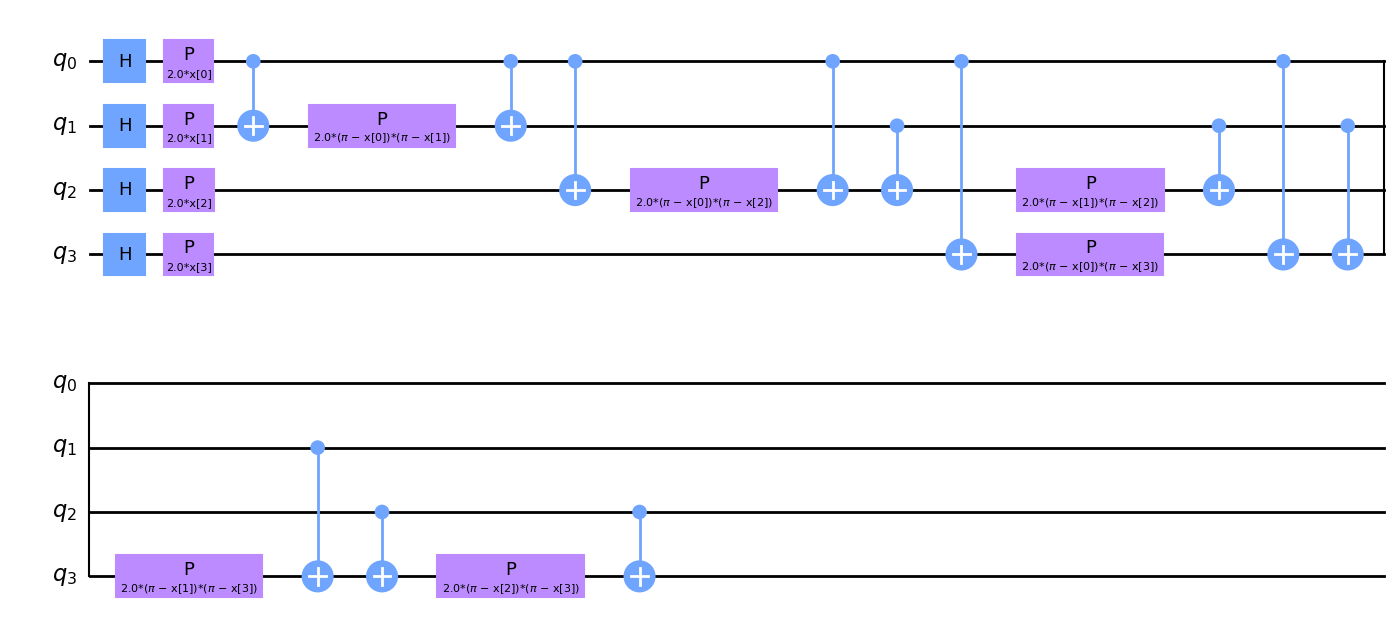

In [16]:
from qiskit.circuit.library import ZZFeatureMap

jum_fitur = x.shape[1]

feature_map = ZZFeatureMap(feature_dimension=jum_fitur, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

#### Parameterized Circuit: Ansatz

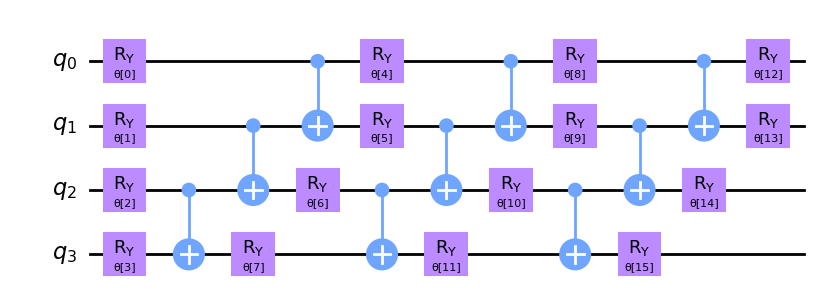

In [18]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=jum_fitur, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

### Optimasi pelatihan menggunakan algoritma COBYLA

In [20]:
from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=40)

In [21]:
from qiskit.primitives import Sampler

sampler = Sampler()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_2260\2087805081.py:3: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


### Buat fungsi untuk menggambar proses pelatihan

In [23]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

### Algoritma QML: VQC

In [25]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)


### Pelatihan

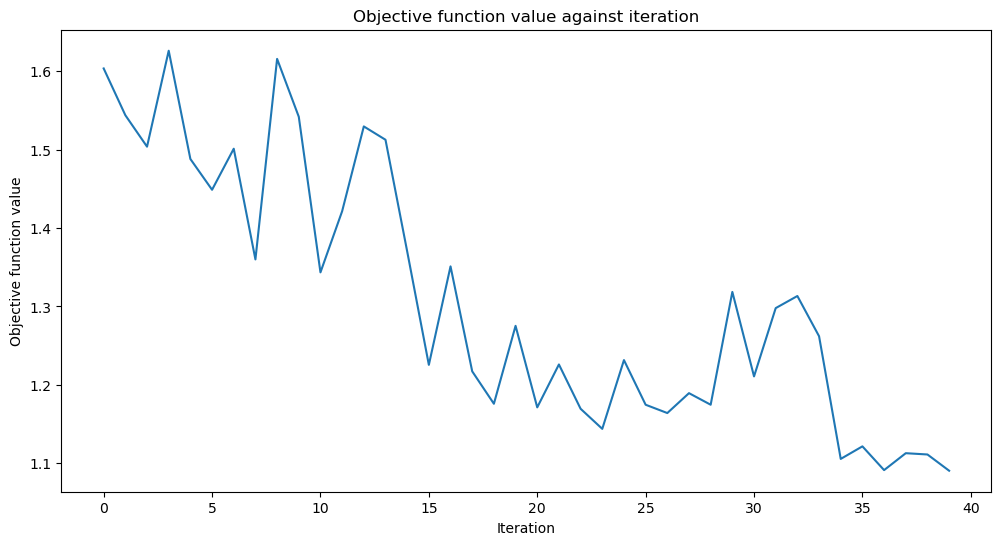

Training time: 29 seconds


In [27]:

objective_func_vals = []

start = time.time()
vqc.fit(train_x, train_y)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

### Pengujian

In [29]:
score_training = vqc.score(train_x, train_y)
score_test = vqc.score(test_x, test_y)

print(f"Quantum VQC on the training dataset: {score_training:.2f}")
print(f"Quantum VQC on the test dataset:     {score_test:.2f}")

Quantum VQC on the training dataset: 0.73
Quantum VQC on the test dataset:     0.47


# Reduksi Jumlah Fitur menggunakan PCA

In [31]:
from sklearn.datasets import load_iris

iris_data = load_iris()

In [32]:
features = iris_data.data
labels = iris_data.target

In [33]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

<Axes: >

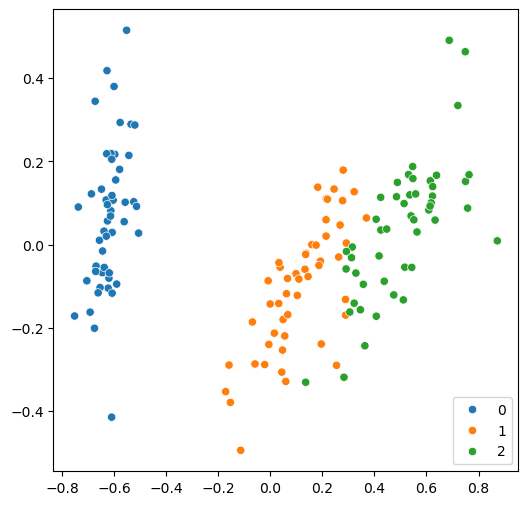

In [34]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

features = PCA(n_components=2).fit_transform(features)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

#### Split Data

In [36]:
train_x, test_x, train_y, test_y = train_test_split(features, labels, train_size=0.8, random_state=algorithm_globals.random_seed)


In [37]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import RealAmplitudes

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

In [38]:
optimizer = COBYLA(maxiter=10)

#### Pelatihan Model

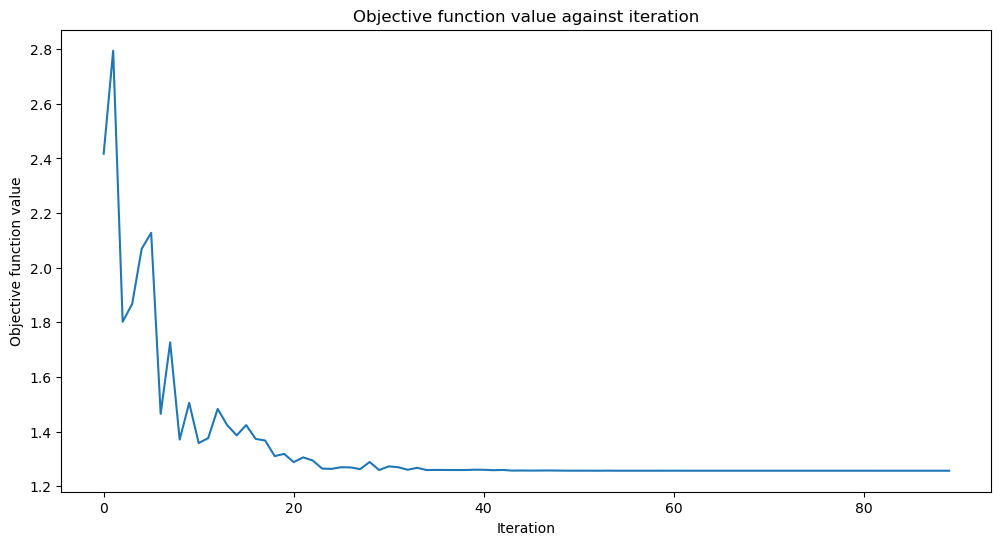

Training time: 102 seconds


In [40]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

# make the objective function plot look nicer.
plt.rcParams["figure.figsize"] = (12, 6)


start = time.time()
vqc.fit(train_x, train_y)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [41]:
train_score_q2_ra = vqc.score(train_x, train_y)
test_score_q2_ra = vqc.score(test_x, test_y)

print(f"Quantum VQC on the training dataset using RealAmplitudes: {train_score_q2_ra:.2f}")
print(f"Quantum VQC on the test dataset using RealAmplitudes:     {test_score_q2_ra:.2f}")

Quantum VQC on the training dataset using RealAmplitudes: 0.61
Quantum VQC on the test dataset using RealAmplitudes:     0.43


#### Menggunakan Ansatz yang lain

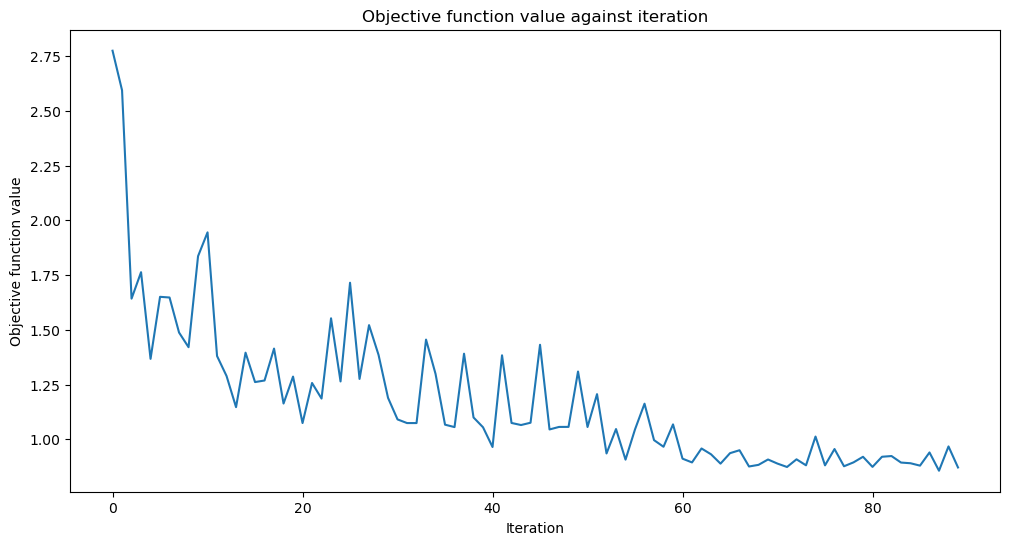

Training time: 171 seconds


In [43]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=num_features, reps=7)
optimizer = COBYLA(maxiter=90)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_x, train_y)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [44]:
train_score_q2_eff = vqc.score(train_x, train_y)
test_score_q2_eff = vqc.score(test_x, test_y)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q2_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q2_eff:.2f}")

Quantum VQC on the training dataset using EfficientSU2: 0.82
Quantum VQC on the test dataset using EfficientSU2:     0.83


# Contoh Regresi dengan Variational Quantum Regressor (VQR)

In [46]:
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=50, n_features=5, noise=1, random_state=42)

In [47]:
from sklearn.preprocessing import MinMaxScaler

x = MinMaxScaler().fit_transform(X)

In [48]:
train_x, test_x, train_y, test_y = train_test_split(x, y, train_size=0.8, random_state=algorithm_globals.random_seed)

In [49]:
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import RealAmplitudes

num_features = x.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

In [50]:
pip install qiskit qiskit-machine-learning


Note: you may need to restart the kernel to use updated packages.


In [51]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=None  # Anda bisa menambahkan callback sesuai kebutuhan
)

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\qiskit_machine_learning\algorithms\regressors\vqr.py:106: UserWarning: No number of qubits was not specified (None) and was retrieved from `circuit` (5). If `circuit` is transpiled, this may cause unstable behaviour.
  neural_network = EstimatorQNN(


In [52]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(train_x, train_y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score result
vqr.score(train_x, train_y)


-0.007226583895042937

In [53]:
# score result
vqr.score(test_x, test_y)


-0.341749836431277